###**Using the dataset of Airline Passengers, I create various models such as Random Forest, Prophet, and ARIMA to identify which one is the best model in terms of accuracy to predict the amount of the passengers in the future.**

In [261]:
! pip install sktime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [262]:
! pip  install statsmodels~=0.13.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [263]:
! pip3 uninstall statsmodels -y

Found existing installation: statsmodels 0.13.5
Uninstalling statsmodels-0.13.5:
  Successfully uninstalled statsmodels-0.13.5


In [264]:
! pip3 install numpy scipy patsy pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [265]:
! pip install statsmodels


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached statsmodels-0.13.5-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.9 MB)


In [266]:
import numpy as np
from sktime.datasets import load_airline
from sktime.forecasting.compose import make_reduction
from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
import pandas as pd
import matplotlib.pyplot as plt
import datetime


%matplotlib inline
import seaborn as sns

pd.options.display.float_format = '{:.2f}'.format

from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy import stats
from statsmodels.tsa import stattools

In [267]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Read the dataset**

In [268]:
air_passengers_df = pd.read_csv('/content/drive/MyDrive/ML_project/ML_timeseries/International_Airline_Passengers/international-airline-passengers.csv')  

In [269]:
# Copying data to another variable to avoid any changes to original data
data=air_passengers_df.copy()

In [270]:
data.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [271]:
data.shape

(144, 2)

In [272]:
print(data)

       Month  \
0    1949-01   
1    1949-02   
2    1949-03   
3    1949-04   
4    1949-05   
..       ...   
139  1960-08   
140  1960-09   
141  1960-10   
142  1960-11   
143  1960-12   

     International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60  
0                                                  112                               
1                                                  118                               
2                                                  132                               
3                                                  129                               
4                                                  121                               
..                                                 ...                               
139                                                606                               
140                                                508                               
141                              

In [273]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                                                                          Non-Null Count  Dtype 
---  ------                                                                          --------------  ----- 
 0   Month                                                                           144 non-null    object
 1   International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [274]:
from datetime import datetime
data['Month']=pd.to_datetime(data['Month'],infer_datetime_format=True)

In [275]:
data.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [276]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                                                                          Non-Null Count  Dtype         
---  ------                                                                          --------------  -----         
 0   Month                                                                           144 non-null    datetime64[ns]
 1   International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


**Put label on each columns**

In [277]:
data.columns = ["Date","# of passengers"]

In [278]:
data.head()

,Date,# of passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [279]:
data.describe()

,# of passengers
count,144.00
mean,280.30
std,119.97
min,104.00
25%,180.00
50%,265.50
75%,360.50
max,622.00


In [280]:
data.info

<bound method DataFrame.info of           Date  # of passengers
0   1949-01-01              112
1   1949-02-01              118
2   1949-03-01              132
3   1949-04-01              129
4   1949-05-01              121
..         ...              ...
139 1960-08-01              606
140 1960-09-01              508
141 1960-10-01              461
142 1960-11-01              390
143 1960-12-01              432

[144 rows x 2 columns]>

In [281]:
# Analyse missing values 
data.isnull().sum()

Date               0
# of passengers    0
dtype: int64

##**Graph**

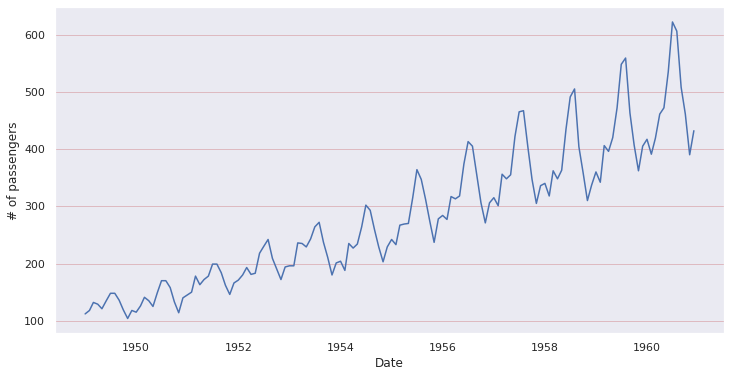

In [282]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=data["Date"], y=data["# of passengers"])
plt.ylabel("# of passengers")
plt.grid(axis="x")
plt.grid(axis="y", color="r", alpha=0.3)
plt.show()

##**Histogram**

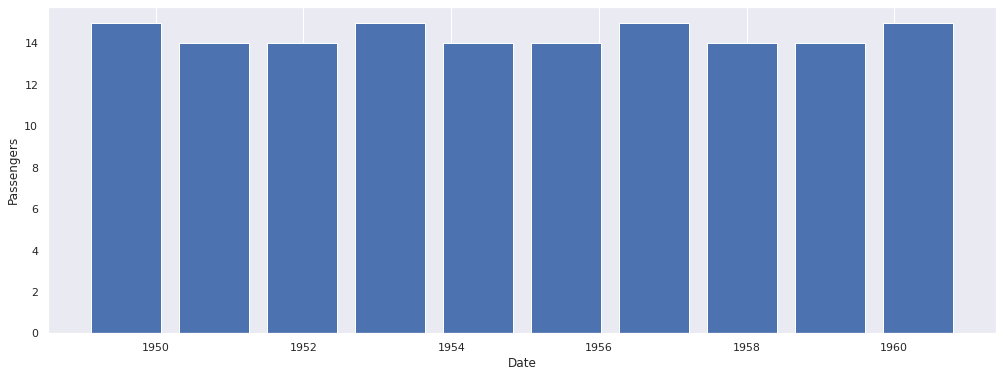

In [283]:
plt.figure(figsize=(17, 6))
plt.hist(x=data["Date"], rwidth=0.8)
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.grid(axis="y")
plt.show()

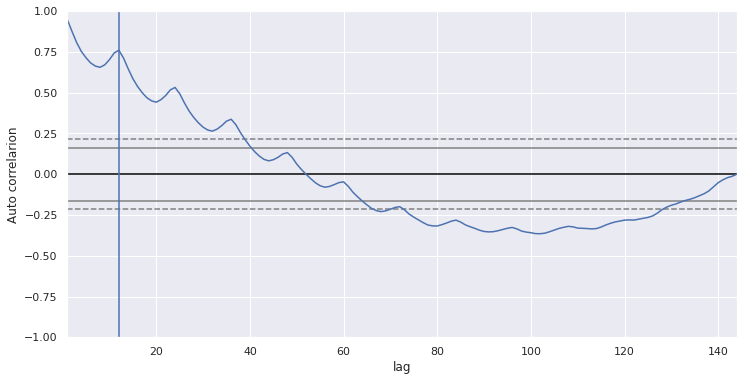

In [284]:
plt.figure(figsize=(12, 6))
pd.plotting.autocorrelation_plot(data["# of passengers"])
plt.grid()
plt.axvline(x=12)
plt.xlabel("lag")
plt.ylabel("Auto correlarion")
plt.show()

In [285]:
stattools.adfuller(data["# of passengers"], autolag="AIC")

(0.8153688792060498,
 0.991880243437641,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)


Results of Dickey Fuller Test:    
Test Statistic: 0.815369    
p-value: 0.991880  
Lags Used: 13.000000  
Number of Observations Used: 130.000000  
Critical Value (1%): -3.481682    
Critical Value (5%): -2.884042  
Critical Value (10%): -2.578770  
dtype: float64  

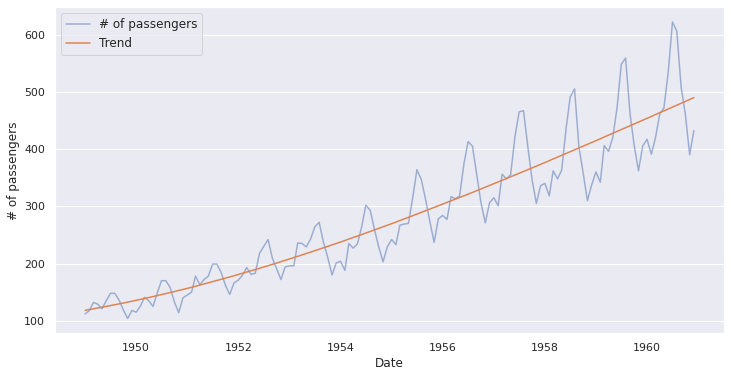

In [286]:
def get_trend(timeseries, deg=3):
    """plot the trend line of time series

    Args:
        timeseries(pd.Series) : data of time series

    Returns:
        pd.Series: time series data correspoding to trends.
    """
    x = list(range(len(timeseries)))
    y = timeseries.values
    coef = np.polyfit(x, y, deg)
    trend = np.poly1d(coef)(x)
    return pd.Series(data=trend, index=timeseries.index)

data["Trend"] = get_trend(data["# of passengers"])

# plot a graph
plt.figure(figsize=(12, 6))
sns.lineplot(x=data["Date"], y=data["# of passengers"], alpha=0.5, label="# of passengers")
sns.lineplot(x=data["Date"], y=data["Trend"], label="Trend")
plt.grid(axis="x")
plt.legend()
plt.show()

##**STL: Seasonal-Trend decomposition**

In [287]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

In [288]:
period = 12
stl = STL(data["# of passengers"], period=period)
dr = stl.fit()

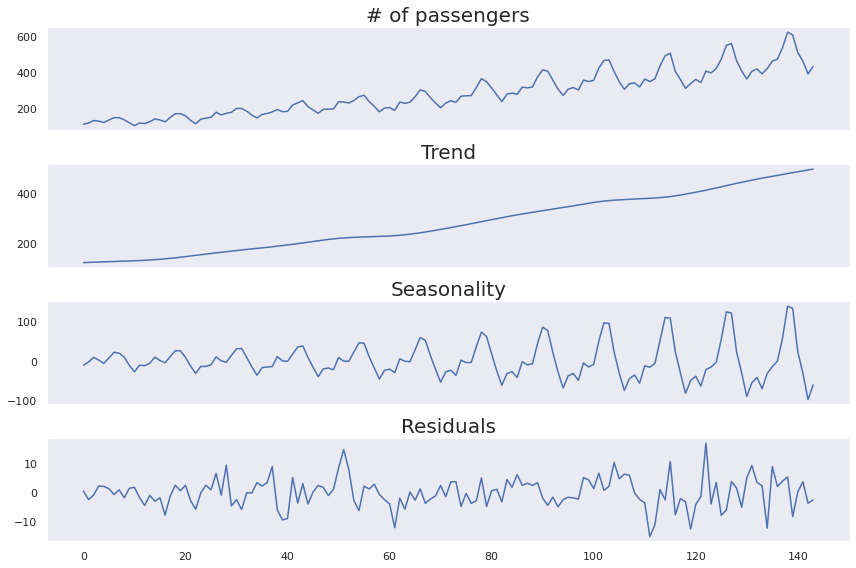

In [289]:
_, axes = plt.subplots(figsize=(12, 8), ncols=1, nrows=4, sharex=True)

axes[0].set_title("# of passengers")
axes[0].plot(dr.observed)
axes[0].grid()

axes[1].set_title("Trend")
axes[1].plot(dr.trend)
axes[1].grid()

axes[2].set_title("Seasonality")
axes[2].plot(dr.seasonal)
axes[2].grid()

axes[3].set_title("Residuals")
axes[3].plot(dr.resid)
axes[3].grid()

plt.tight_layout()
plt.show()


##**Test if it is robust to outliers**

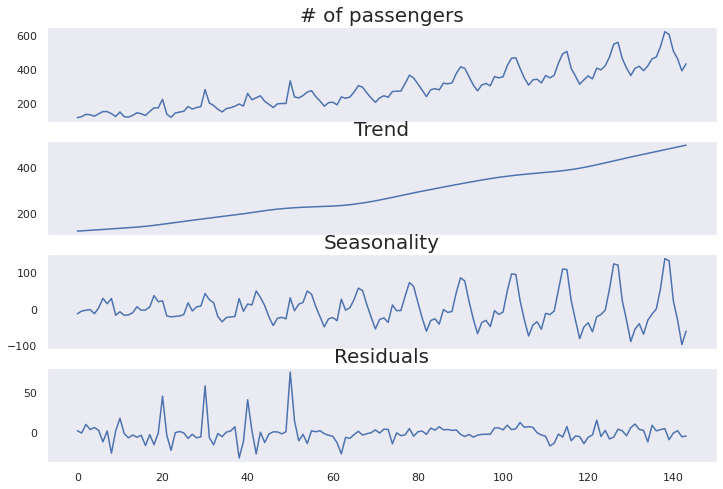

In [290]:
def check_outlier():
    period = 12
    df_outlier = data["# of passengers"].copy()

    for i in range(1, 6):
        df_outlier[i * 10] = df_outlier[i * 10] * 1.4 #1.4 times weighted to outliers

    stl = STL(df_outlier, period=period, trend=31)
    dr_outlier = stl.fit()

    _, axes = plt.subplots(figsize=(12, 8), ncols=1, nrows=4, sharex=True)

    axes[0].set_title("# of passengers")
    axes[0].plot(dr_outlier.observed)
    axes[0].grid()

    axes[1].set_title("Trend")
    axes[1].plot(dr_outlier.trend)
    axes[1].grid()

    axes[2].set_title("Seasonality")
    axes[2].plot(dr_outlier.seasonal)
    axes[2].grid()

    axes[3].set_title("Residuals")
    axes[3].plot(dr_outlier.resid)
    axes[3].grid()


check_outlier()

**Observation: We can see it is robust to outliers. Compared to the plot without outliers, it is not much different.**

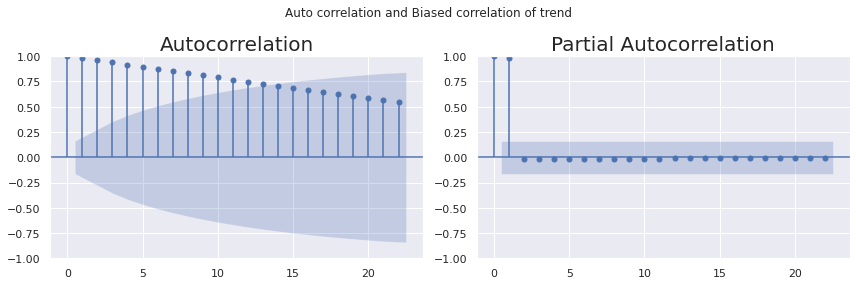

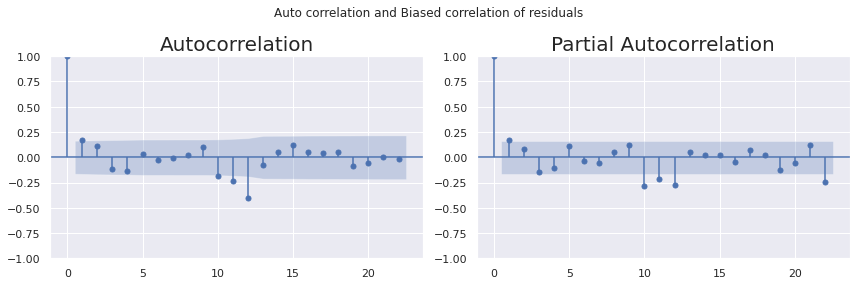

In [291]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

_, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
plt.suptitle("Auto correlation and Biased correlation of trend")
plot_acf(dr.trend.dropna(), ax=axes[0])
plot_pacf(dr.trend.dropna(), method="ywm", ax=axes[1])
plt.tight_layout()
plt.show()

_, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
plt.suptitle("Auto correlation and Biased correlation of residuals")
plot_acf(dr.resid.dropna(), ax=axes[0])
plot_pacf(dr.resid.dropna(), method="ywm", ax=axes[1])
plt.tight_layout()
plt.show()

###**Portmanteau test in the residuals**

In [292]:
from statsmodels.stats.diagnostic import acorr_ljungbox

acorr_ljungbox(dr.resid.dropna(), lags=int(np.log(data.shape[0])))

,lb_stat,lb_pvalue
1,4.51,0.03
2,6.39,0.04
3,8.24,0.04
4,10.94,0.03


**Observation: P-value is less than 0.05.**

###**Trend approximation**

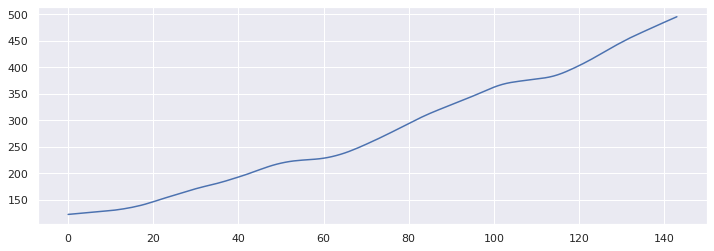

In [293]:
plt.figure(figsize=(12, 4))
trend_data = dr.trend.dropna()
plt.plot(trend_data)
plt.show()

**Remove the trend from the original data.**  
**Prepre the data with only trend.**  

In [294]:
trend_data_first, trend_data_last = trend_data.iloc[0], trend_data.iloc[-1]

for i in range(int(period / 2)):
    trend_data[trend_data.index.min() - 1] = trend_data_first
    trend_data[trend_data.index.max() + 1] = trend_data_last

trend_data.sort_index()

-6     122.63
-5     122.63
-4     122.63
-3     122.63
-2     122.63
        ...  
 145   495.53
 146   495.53
 147   495.53
 148   495.53
 149   495.53
Name: trend, Length: 156, dtype: float64

**Comparison of a plot with trend and a plot without trend.**

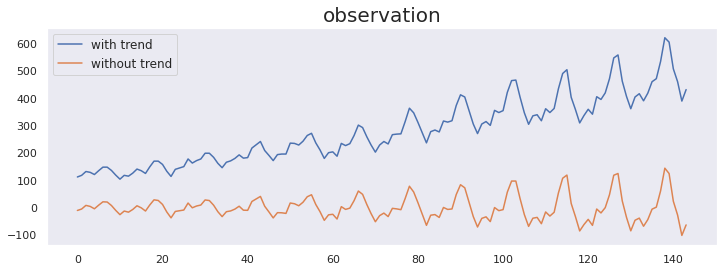

In [295]:
plt.figure(figsize=(12, 4))
plt.title("observation")
plt.plot(dr.observed, label="with trend")
plt.plot(dr.observed - trend_data, label="without trend")
plt.grid()
plt.legend()

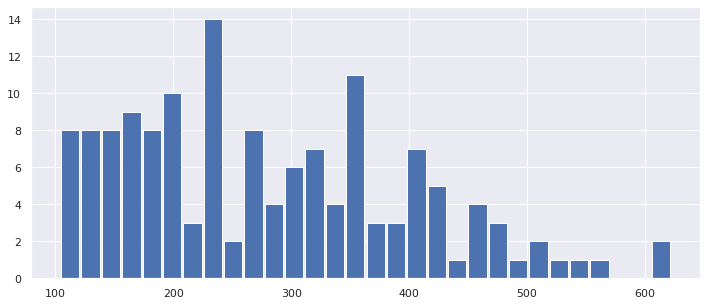

In [302]:
from scipy import stats
import numpy as np

plt.figure(figsize=(12, 5))
data_wb = data['# of passengers']
plt.hist(data_wb, bins=30, rwidth=0.9)
plt.show()

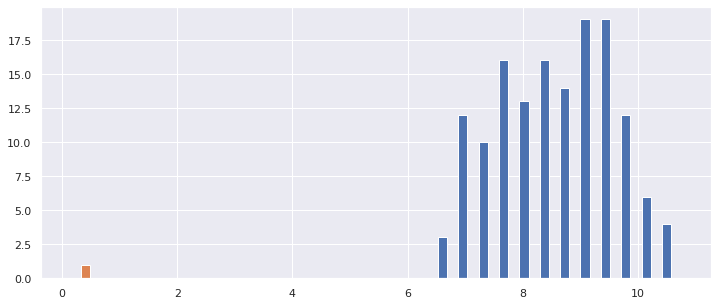

In [303]:
#By Boxcox, we make the above plot to like normal distribution.(it cannot apply to the data including less than 0.)

from scipy.stats import boxcox

plt.figure(figsize=(12, 5))
plt.hist(boxcox(data_wb), bins=30, rwidth=0.9)
plt.show()

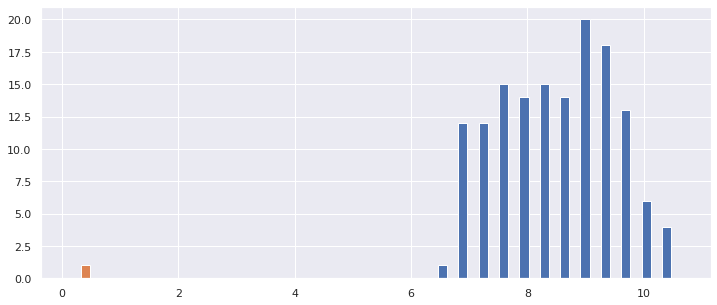

In [304]:
#By Yeojohnson, we make the above plot to like normal distribution.(it can apply to the data including less than 0.)
from scipy.stats import yeojohnson

plt.figure(figsize=(12, 5))
plt.hist(yeojohnson(data_wb), bins=30, rwidth=0.9)
plt.show()

##**Moving Average**

##**SMA: Simple Moving Average**

<Axes: >

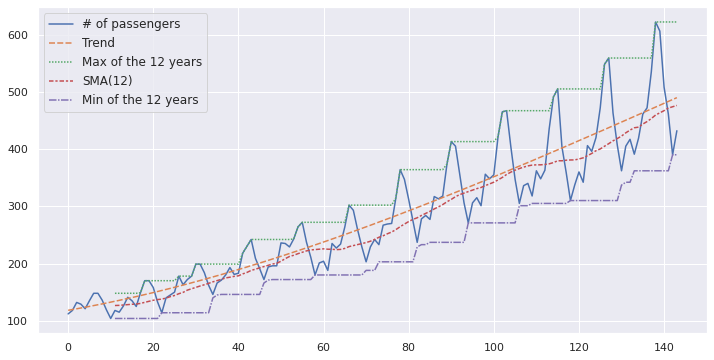

In [305]:
data_example = data.copy()
data_example["Max of the 12 years"] = (
    data_example["# of passengers"].rolling(12).max()
)
data_example["SMA(12)"] = (
    data_example["# of passengers"].rolling(12).mean()
)
data_example["Min of the 12 years"] = (
    data_example["# of passengers"].rolling(12).min()
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=data_example)

##**Weighted Moving Average**

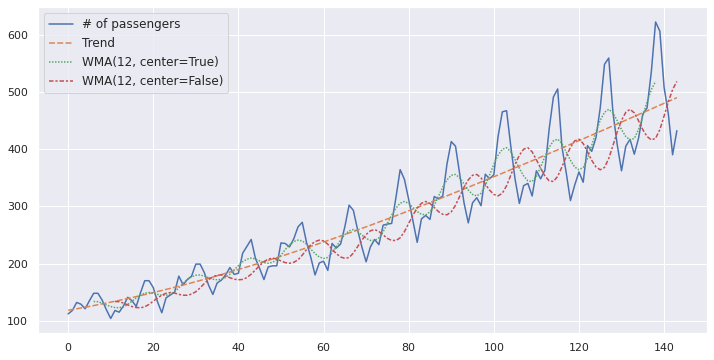

In [306]:
def get_wma(s, w=np.array([0, 1, 2, 3, 4, 5, 5, 4, 3, 2, 1, 0])):
    """find moving average

    Args:
        s (numpy.ndarray): time series data
        w (numpy.ndarray, optional): weight

    Returns:
        time series data aft calc of weighted moving average(numpy.ndarray)
    """
    return np.sum(w * s) / w.sum()


data_example = data.copy()
data_example["WMA(12, center=True)"] = (
    data_example["# of passengers"]
    .rolling(12, center=True)
    .apply(get_wma, raw=True)
)
data_example["WMA(12, center=False)"] = (
    data_example["# of passengers"]
    .rolling(12, center=False)
    .apply(get_wma, raw=True)
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=data_example)
plt.show()

##**EMA: Exponential Moving Average**

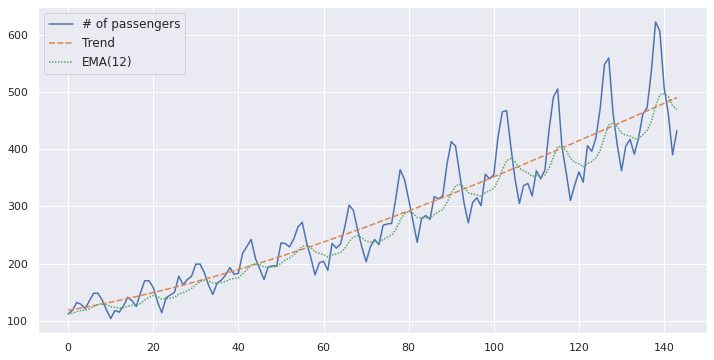

In [307]:
data_example = data.copy()
data_example["EMA(12)"] = (
    data_example["# of passengers"].ewm(span=12, adjust=False).mean()
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=data_example)
plt.show()

##**Exponential Smoothing model**

****Read the dataset again same data in case**

In [308]:
air_passengers_df = pd.read_csv('/content/drive/MyDrive/ML_project/ML_timeseries/International_Airline_Passengers/international-airline-passengers.csv')

In [309]:
air_passengers_df.head() 

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [310]:
data2=air_passengers_df.copy()

In [311]:
data2.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [312]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                                                                          Non-Null Count  Dtype 
---  ------                                                                          --------------  ----- 
 0   Month                                                                           144 non-null    object
 1   International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [313]:
data2 = pd.DataFrame(data2)
data2.rename(columns={ "International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60": "passengers"}, inplace=True)
#data2.index = pd.to_datetime(data.index)
#data2 = data2.asfreq("MS")
data2.head()

,Month,passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [314]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [315]:
from datetime import datetime
data2['Month']=pd.to_datetime(data2['Month'],infer_datetime_format=True)

In [316]:
data2.head()

,Month,passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [317]:
data2 = data2.set_index('Month',inplace=False)

In [318]:
data2.head()

,passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


**We split the data as train data and test data. The test data predicts after "1957-01-01".**

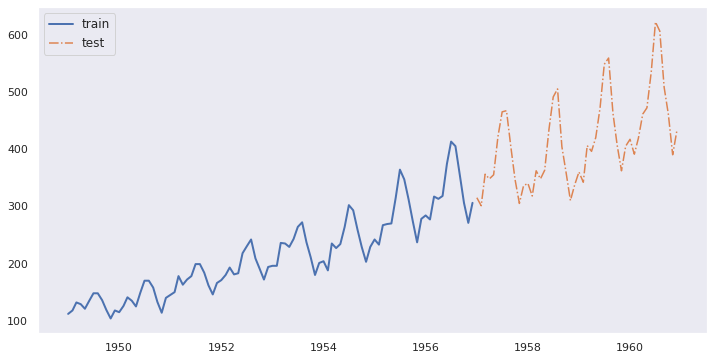

In [319]:
data_train =  data2[data2.index  < "1957-01-01"]
data_test =  data2[data2.index  >= "1957-01-01"]

plt.figure(figsize=(12, 6))
plt.plot(data_train.index, data_train.values, label="train", linewidth=2)
plt.plot(data_test.index, data_test.values, "-.", label="test")
plt.legend()
plt.grid()

In [320]:
from statsmodels.tsa.api import SimpleExpSmoothing

# Ensure data_train is a pandas series or numpy array
data_train = data_train.squeeze()

ses = SimpleExpSmoothing(data_train)
ses = ses.fit(smoothing_level=0.1)
pred = ses.forecast(33)

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [321]:
ses = SimpleExpSmoothing(data_train)
ses = ses.fit(smoothing_level=0.1)
pred = ses.forecast(33)

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



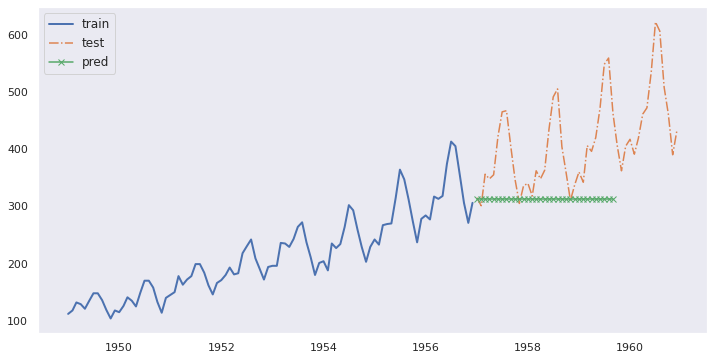

In [322]:
plt.figure(figsize=(12, 6))
plt.plot(data_train.index, data_train.values, label="train", linewidth=2)
plt.plot(data_test.index, data_test.values, "-.", label="test")
plt.plot(pred.index, pred.values, "-x", label="pred")
plt.legend()
plt.grid()


##**Holt’s Linear Smoothing model**  

In [323]:
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

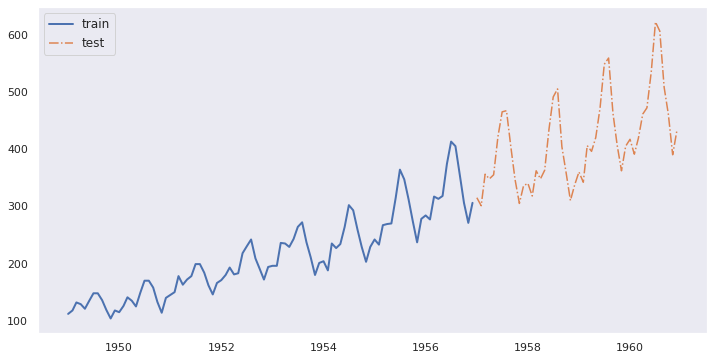

In [324]:
data_train = data2[data2.index < "1957-01-01"]
data_test = data2[data2.index >= "1957-01-01"]

plt.figure(figsize=(12, 6))
plt.plot(data_train.index, data_train.values, label="train", linewidth=2)
plt.plot(data_test.index, data_test.values, "-.", label="test")
plt.legend()
plt.grid()

In [325]:
ses = SimpleExpSmoothing(data_train)
ses = ses.fit(smoothing_level=0.1)
ses_pred = ses.forecast(33)

holt = Holt(data_train)
holt = holt.fit(smoothing_level=0.1, smoothing_trend=0.2)
holt_pred = holt.forecast(33)

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



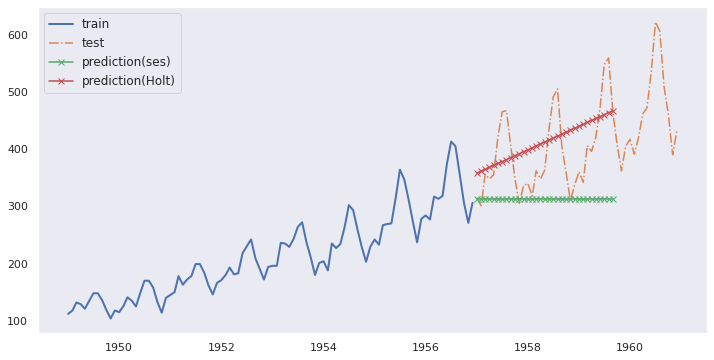

In [326]:
plt.figure(figsize=(12, 6))
plt.plot(data_train.index, data_train.values, label="train", linewidth=2)
plt.plot(data_test.index, data_test.values, "-.", label="test")
plt.plot(ses_pred.index, ses_pred.values, "-x", label="prediction(ses)")
plt.plot(holt_pred.index, holt_pred.values, "-x", label="prediction(Holt)")
plt.legend()
plt.grid()

###**MAE, RMSE, and MAPE of SES**

In [327]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(np.array(data_test[-33:]), np.array(ses_pred))*10
mse = mean_squared_error(np.array(data_test[-33:]), np.array(ses_pred))
rmse = np.sqrt(mse)*10 
mape = np.mean(np.abs((np.array(data_test[-33:]) - np.array(ses_pred)) / np.array(data_test[-33:]))) * 1000
print('MAE: %.3f' % mae)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

MAE: 1240.262
RMSE: 1456.387
MAPE: 263.130


###**MAE, RMSE, and MAPE of Holt’s Linear Smoothing model**

In [328]:
mae = mean_absolute_error(np.array(data_test[-33:]), np.array(holt_pred))*10
mse = mean_squared_error(np.array(data_test[-33:]), np.array(holt_pred))
rmse = np.sqrt(mse)*10 
mape = np.mean(np.abs((np.array(data_test[-33:]) - np.array(holt_pred)) / np.array(data_test[-33:]))) * 1000
print('MAE: %.3f' % mae)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

MAE: 547.041
RMSE: 729.674
MAPE: 148.436


##**Holt-Winters**    

In [329]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [330]:
ses = SimpleExpSmoothing(data_train)
ses = ses.fit(smoothing_level=0.1)
ses_pred = ses.forecast(33)

holt = Holt(data_train)
holt = holt.fit(smoothing_level=0.1, smoothing_trend=0.2)
holt_pred = holt.forecast(33)

hw = ExponentialSmoothing(
    data_train, trend="additive", seasonal="add", seasonal_periods=12
)
hw = hw.fit()
hw_pred = hw.forecast(33)

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



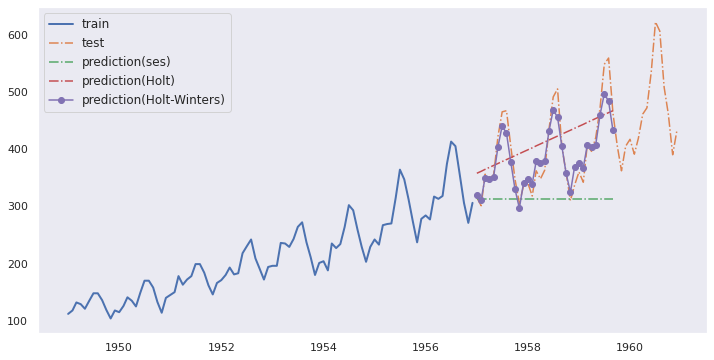

In [331]:
plt.figure(figsize=(12, 6))
plt.plot(data_train.index, data_train.values, label="train", linewidth=2)
plt.plot(data_test.index, data_test.values, "-.", label="test")
plt.plot(ses_pred.index, ses_pred.values, "-.", label="prediction(ses)")
plt.plot(holt_pred.index, holt_pred.values, "-.", label="prediction(Holt)")
plt.plot(hw_pred.index, hw_pred.values, "-o", label="prediction(Holt-Winters)")
plt.legend()
plt.grid()

###**MAE, RMSE, and MAPE of Holt-Winters**

In [332]:
mae = mean_absolute_error(np.array(data_test[-33:]), np.array(hw_pred))*10
mse = mean_squared_error(np.array(data_test[-33:]), np.array(hw_pred))
rmse = np.sqrt(mse)*10 
mape = np.mean(np.abs((np.array(data_test[-33:]) - np.array(hw_pred)) / np.array(data_test[-33:]))) * 1000
print('MAE: %.3f' % mae)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

MAE: 815.900
RMSE: 987.849
MAPE: 176.748


##**Prophet**  

In [333]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [334]:
from prophet import Prophet

In [335]:
# parameter of plot
sns.set(
    rc={
        "figure.figsize": (12, 4),
        "legend.fontsize": "large",
        "figure.titlesize": "large",
        "axes.titlesize": 20,
    }
)

In [336]:
df = pd.read_csv('/content/drive/MyDrive/ML_project/ML_timeseries/International_Airline_Passengers/international-airline-passengers.csv')
df.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [337]:
data3=df.copy()

In [338]:
data3.rename(columns = {'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60':'AirPassengers'}, inplace = True)

In [339]:
data3.head()

,Month,AirPassengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [340]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Month          144 non-null    object
 1   AirPassengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [341]:
data3['Month'] = pd.DatetimeIndex(data3['Month'])
data3.dtypes

Month            datetime64[ns]
AirPassengers             int64
dtype: object

In [342]:
df = data3.rename(columns={'Month': 'ds',
                        'AirPassengers': 'y'})

df.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


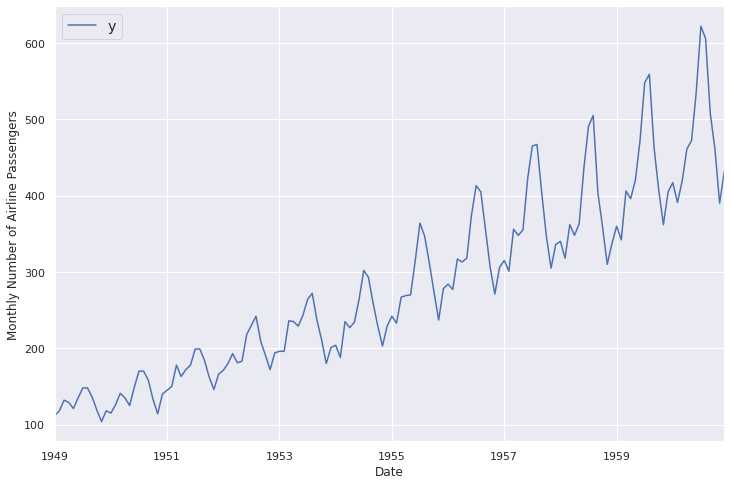

In [343]:
ax = df.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Monthly Number of Airline Passengers')
ax.set_xlabel('Date')

plt.show()

##**Time Series Forecast with Prophet**

In [344]:
# set the uncertainty interval as 75%. The default is 80%
m = Prophet(interval_width=0.75)

In [345]:
m.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf7jukedp/u_ddfi92.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf7jukedp/zftclroc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37785', 'data', 'file=/tmp/tmpf7jukedp/u_ddfi92.json', 'init=/tmp/tmpf7jukedp/zftclroc.json', 'output', 'file=/tmp/tmpf7jukedp/prophet_model0qtbx0w4/prophet_model-20230323175437.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:54:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:54:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


**Predict 144 months(12years) ahead of the future with each point at the end of month.**

In [346]:
future_dates = m.make_future_dataframe(periods=144, freq='M')
future_dates = future_dates + pd.offsets.MonthEnd(0)
future_dates.head()

,ds
0,1949-01-31
1,1949-02-28
2,1949-03-31
3,1949-04-30
4,1949-05-31


In [347]:
forecast = m.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,1949-01-31,73.22,48.49,100.34
1,1949-02-28,117.43,90.63,141.05
2,1949-03-31,104.82,78.89,130.91
3,1949-04-30,115.29,88.43,141.98
4,1949-05-31,148.64,123.54,175.26


In [348]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
283,1972-07-31,981.38,948.38,1016.38
284,1972-08-31,934.81,901.57,971.37
285,1972-09-30,898.06,866.70,934.59
286,1972-10-31,867.27,834.06,904.96
287,1972-11-30,896.92,862.51,934.34


###**MAE, RMSE, and MAPE of Prophet**

In [349]:
y_true = df['y'].values
y_pred = forecast['yhat'][-144:].values
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse) 
mape = np.mean(np.abs((y_true - y_pred) / y_true))*100
print('MAE: %.3f' % mae)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

MAE: 427.717
RMSE: 428.806
MAPE: 180.997


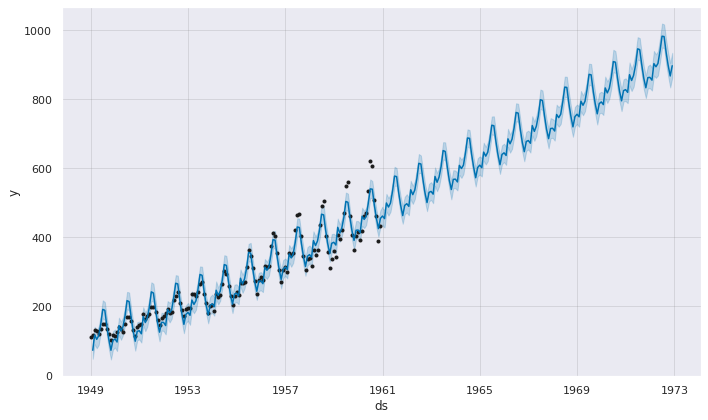

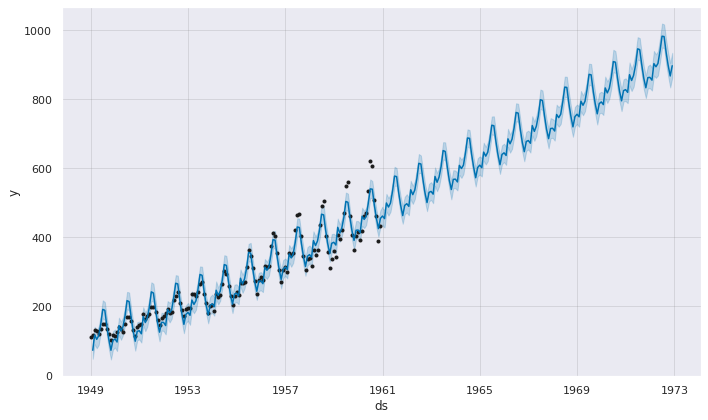

In [350]:
m.plot(forecast,uncertainty=True)

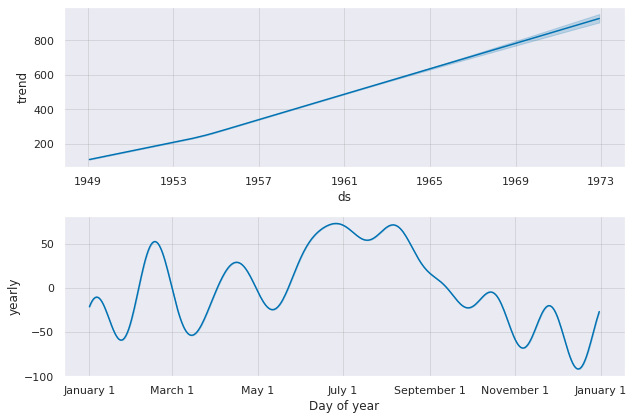

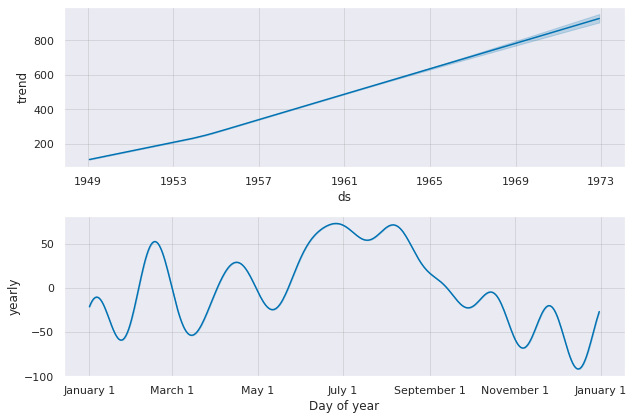

In [351]:
m.plot_components(forecast)

**Insight: The first plot shows the passengers are incireasing year by year.  
The second plot explains the peak of the numbers of passengers is during the summer. Especially, July and Aug are the highest month.**

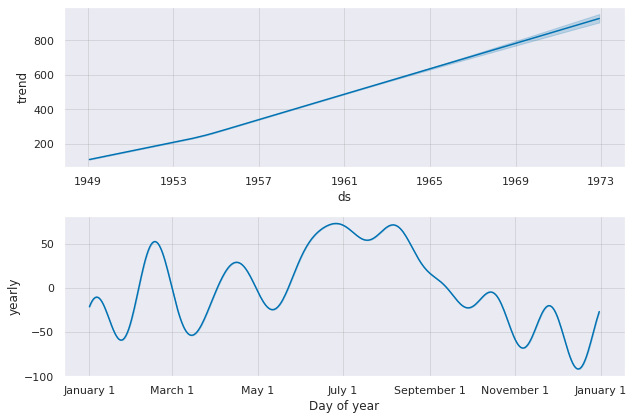

In [352]:
fig1 = m.plot_components(forecast)

In [353]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [354]:
plot_components_plotly(m, forecast)

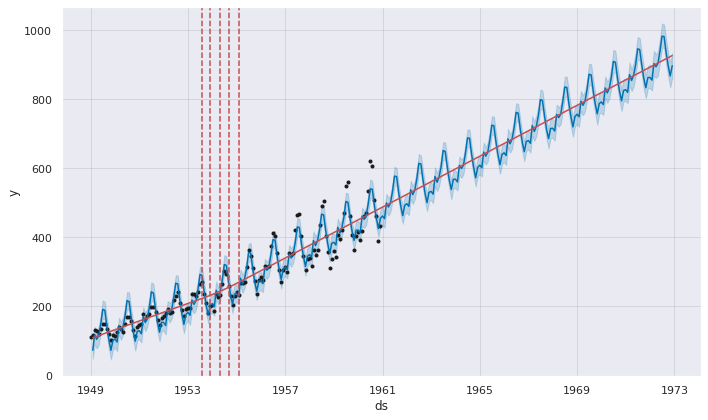

In [355]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [356]:
m.changepoints

5     1949-06-01
9     1949-10-01
14    1950-03-01
18    1950-07-01
23    1950-12-01
27    1951-04-01
32    1951-09-01
36    1952-01-01
41    1952-06-01
46    1952-11-01
50    1953-03-01
55    1953-08-01
59    1953-12-01
64    1954-05-01
68    1954-09-01
73    1955-02-01
78    1955-07-01
82    1955-11-01
87    1956-04-01
91    1956-08-01
96    1957-01-01
100   1957-05-01
105   1957-10-01
109   1958-02-01
114   1958-07-01
Name: ds, dtype: datetime64[ns]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf7jukedp/tzo0_ttc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf7jukedp/zvz6y6f2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7036', 'data', 'file=/tmp/tmpf7jukedp/tzo0_ttc.json', 'init=/tmp/tmpf7jukedp/zvz6y6f2.json', 'output', 'file=/tmp/tmpf7jukedp/prophet_model55iophwm/prophet_model-20230323175526.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:55:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:55:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


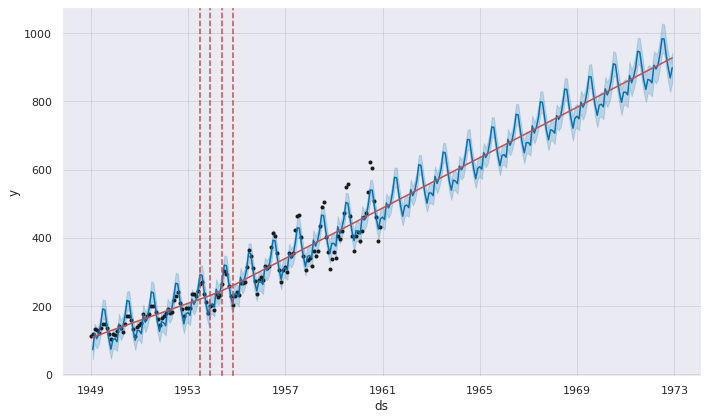

In [357]:
pro_change= Prophet(changepoint_range=0.95)
forecast = pro_change.fit(df).predict(future_dates)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf7jukedp/zx8n8eu0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf7jukedp/kt9q9aa3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97656', 'data', 'file=/tmp/tmpf7jukedp/zx8n8eu0.json', 'init=/tmp/tmpf7jukedp/kt9q9aa3.json', 'output', 'file=/tmp/tmpf7jukedp/prophet_modelpzerojng/prophet_model-20230323175531.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:55:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:55:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


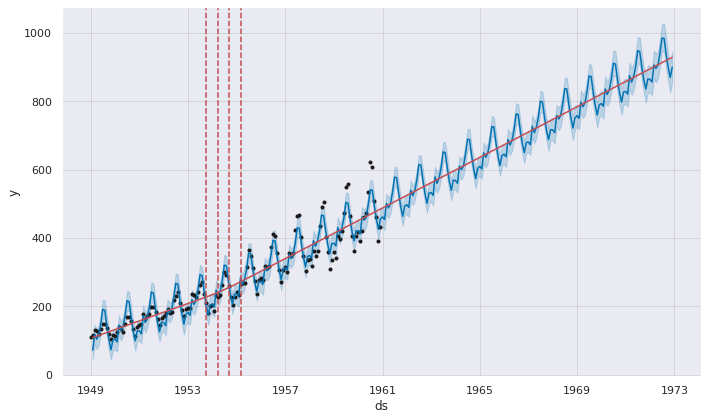

In [358]:
pro_change= Prophet(n_changepoints=20, yearly_seasonality=True)
forecast = pro_change.fit(df).predict(future_dates)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf7jukedp/f8605j1p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf7jukedp/4_4h6vu9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31580', 'data', 'file=/tmp/tmpf7jukedp/f8605j1p.json', 'init=/tmp/tmpf7jukedp/4_4h6vu9.json', 'output', 'file=/tmp/tmpf7jukedp/prophet_model1lc27jv9/prophet_model-20230323175535.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:55:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:55:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


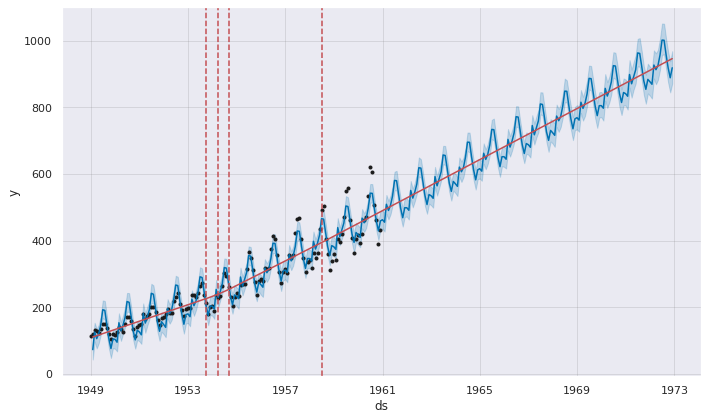

In [359]:
pro_change= Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.1)
forecast = pro_change.fit(df).predict(future_dates)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

##**Random Forest Model**

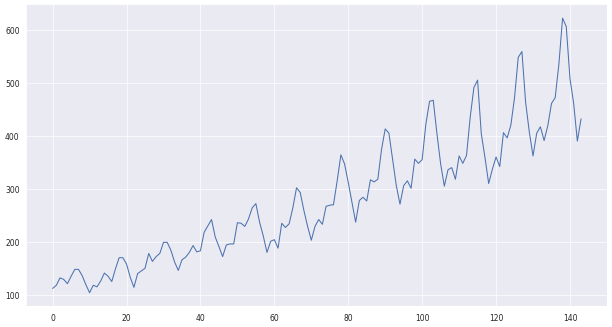

In [360]:
fig = plt.figure(figsize=(15, 8), dpi=50)
ax1 = plt.axes()
ax1.plot(data['# of passengers'].values)

**The data has trend and specific periodical behaive.**

In [361]:
import statsmodels.api as sm

**Let see how the data will be with time series.**

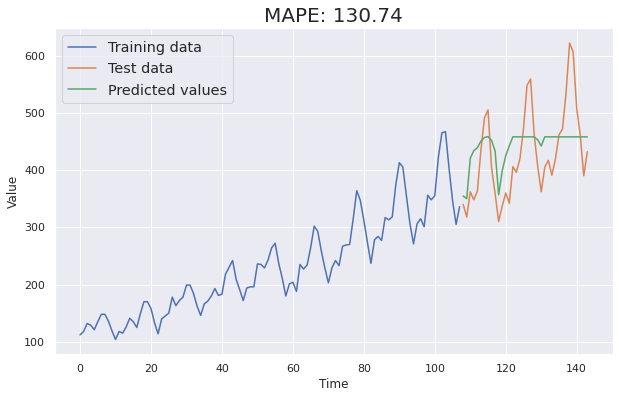

In [362]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.compose import make_reduction
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt

# Split data into train and test sets
y_train, y_test = temporal_train_test_split(data['# of passengers'])

# Define the random forest regressor
regressor = RandomForestRegressor()

# Define the reduction strategy for the forecaster
forecaster = make_reduction(
    regressor,
    strategy="recursive",
    window_length=12,
    scitype="infer",
)

# Fit the forecaster to the training data
forecaster.fit(y_train)

# Define the forecasting horizon
fh = np.arange(1, len(y_test) + 1)

# Predict the test set using the forecaster
y_pred = forecaster.predict(fh)

# Calculate the MAPE
mape = MeanAbsolutePercentageError()
mape_val = mape(y_test, y_pred)*1000

# Plot the prediction and the actual values
plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Training data')
plt.plot(y_test.index, y_test, label='Test data')
plt.plot(y_test.index, y_pred, label='Predicted values')
plt.title(f'MAPE: {mape_val:.2f}')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

**Insight: It seems there are errors since the prediction becomes straight line.**  

###**MAE, RMSE, and MAPE of Random Forest**

In [363]:
mae = mean_absolute_error(y_test, y_pred)*10
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)*10
mape = np.mean(np.abs((y_test - y_pred) / y_test))*1000
print('MAE: %.3f' % mae)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

MAE: 555.497
RMSE: 661.884
MAPE: 130.736


In [364]:
mape = MeanAbsolutePercentageError()
print(f"mape = {mape(y_test, y_pred)}")

mape = 0.13073567221332422


##**ARIMA model**  
ARIMA model is combining AR model and MA model.  

In [365]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached statsmodels-0.13.5-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.9 MB)


mape = 0.04356744949188808


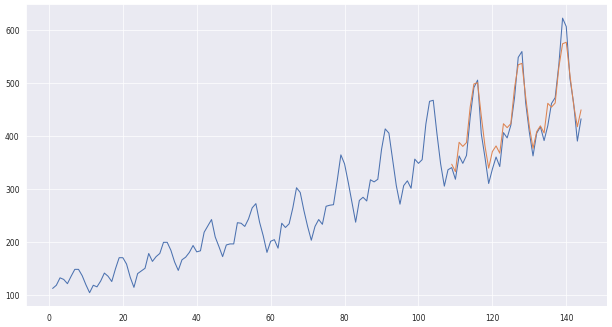

In [369]:
from sktime.forecasting.arima import ARIMA

forecaster = ARIMA(
    order=(1, 1, 0),
    seasonal_order=(0, 1, 0, 12),
    suppress_warnings=True)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

mape = MeanAbsolutePercentageError()

print(f"mape = {mape(y_test, y_pred)}")

fig = plt.figure(figsize=(15, 8), dpi=50)
ax1 = plt.axes()
ax1.plot(np.arange(1, len(data['# of passengers']) + 1), data['# of passengers'].values)
ax1.plot(np.arange(len(y_train)+1, len(data['# of passengers']) + 1), y_pred.values)

**Insight: MAPE is improving compared to the previous plot with 0.13 to this plot 0.043.
The grap is also improving but the 3rd peak is different.**  

###**MAE, RMSE, and MAPE of ARIMA**

In [370]:
mae = mean_absolute_error(y_test, y_pred)*10
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)*10
mape = np.mean(np.abs((y_test - y_pred) / y_test))*1000
print('MAE: %.3f' % mae)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

MAE: 178.189
RMSE: 211.878
MAPE: 43.567


##**Auto ARIMA**

mape = 0.04148971434138202


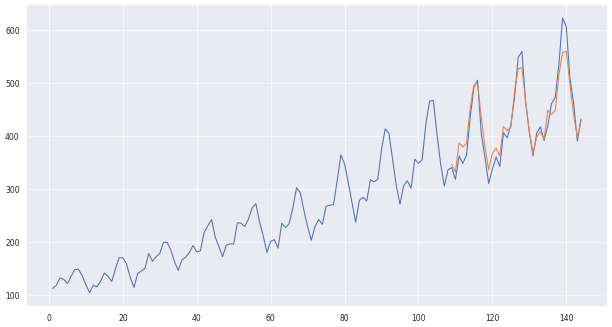

In [367]:
from sktime.forecasting.arima import AutoARIMA
forecaster = AutoARIMA(sp=12, d=None, max_p=10, max_q=10, suppress_warnings=True)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

mape = MeanAbsolutePercentageError()
print(f"mape = {mape(y_test, y_pred)}")

fig = plt.figure(figsize=(15, 8), dpi=50)
ax1 = plt.axes()
ax1.plot(np.arange(1, len(data['# of passengers']) + 1),data['# of passengers'].values)
ax1.plot(np.arange(len(y_train)+1, len(data['# of passengers']) + 1), y_pred.values)

**Insight: The MAPE is improving from 0.043 to 0.041.**  

###**MAE, RMSE, and MAPE of Auto ARIMA**

In [368]:
mae = mean_absolute_error(y_test, y_pred)*10
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)*10
mape = np.mean(np.abs((y_test - y_pred) / y_test))*1000
print('MAE: %.3f' % mae)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

MAE: 178.078
RMSE: 221.322
MAPE: 41.490


##**Conclustion:**    
**We comapre MAE, RMSE, and MAPE.  
The MAE, RMSE, and MAPE of Auto ARIMA is absolutely lower than other models. All of the numbers are lower is better. Auto ARIMA has the lowest numbers of all of the score.**  